# Introduction to Statistical Learning Lab 4 - Classification

This post is the third in a series where I work through [Intro to Statistical Learning](https://www.statlearning.com/) in python instead of R as done in the text. In this post I'll work through the lab for chapter 4, on classification. The second edition is coming in summer 2021, but I'm working through the first edition. You can find a free PDF [here](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from IPython.display import display, Markdown
pd.options.display.max_rows = 999
%matplotlib inline

In [2]:
def printm(input_str):
    display(Markdown(input_str))

## 4.6.2 The stock market data

In [3]:
df = sm.datasets.get_rdataset("Smarket", "ISLR", cache=True).data

In [4]:
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [5]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [6]:
df.corr().style.background_gradient(cmap='viridis')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


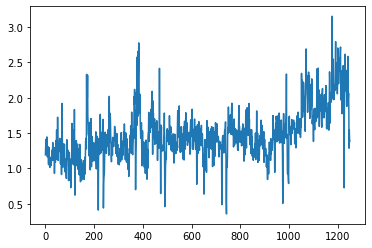

In [7]:
df["Volume"].plot();

## 4.6.2 Logistic Regression

In [8]:
y = pd.get_dummies(df["Direction"])["Up"]
X = df.drop(columns=["Direction", "Today", "Year"])

In [9]:
logit = sm.Logit(y, sm.add_constant(X)).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 2.197001
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                     Up   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sat, 15 May 2021   Pseudo R-squ.:                     inf
Time:                        17:01:00   Log-Likelihood:                -2746.3
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

/home/ipreston/miniconda3/envs/isl/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ipreston/miniconda3/envs/isl/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ipreston/miniconda3/envs/isl/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Access the coefficients and p values

In [10]:
logit.params

const    -0.126000
Lag1     -0.073074
Lag2     -0.042301
Lag3      0.011085
Lag4      0.009359
Lag5      0.010313
Volume    0.135441
dtype: float64

In [11]:
logit.pvalues

const     0.600700
Lag1      0.145232
Lag2      0.398352
Lag3      0.824334
Lag4      0.851445
Lag5      0.834998
Volume    0.392404
dtype: float64

Display the first 10 predicted probabilities from the training data

In [12]:
predict_prob = logit.predict(sm.add_constant(X))
predict_prob[:10]

0    0.507084
1    0.481468
2    0.481139
3    0.515222
4    0.510781
5    0.506956
6    0.492651
7    0.509229
8    0.517614
9    0.488838
dtype: float64

Note to self, don't call fittedvalues for logistic regression, it just returns the dot product of the training exogenous variables and the coefficients.

Make a confusion matrix

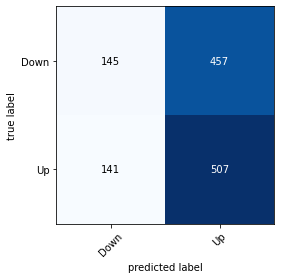

In [13]:
class_labels = ["Down", "Up"] # took the Up dummy column as my independent variable, so 1 = Up
predict_class = pd.Series(data=0, index=predict_prob.index)
predict_class.loc[predict_prob > 0.5] = 1
confusion_mat = confusion_matrix(y, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

Train test split

In [14]:
train_mask = df["Year"] < 2005
train_df = df.loc[train_mask].copy()
test_df = df.loc[~train_mask].copy()

In [15]:
y_train = pd.get_dummies(train_df["Direction"])["Up"]
X_train = train_df.drop(columns=["Direction", "Today", "Year"])
y_test = pd.get_dummies(test_df["Direction"])["Up"]
X_test = test_df.drop(columns=["Direction", "Today", "Year"])

In [16]:
logit = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 3.346650
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                     Up   No. Observations:                  998
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            6
Date:                Sat, 15 May 2021   Pseudo R-squ.:                     inf
Time:                        17:01:00   Log-Likelihood:                -3340.0
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1912      0.334      0.573      0.567      -0.463       0.845
Lag1          -0.0542      0.

/home/ipreston/miniconda3/envs/isl/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ipreston/miniconda3/envs/isl/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ipreston/miniconda3/envs/isl/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [17]:
predict_prob = logit.predict(sm.add_constant(X_test))

Make a confusion matrix

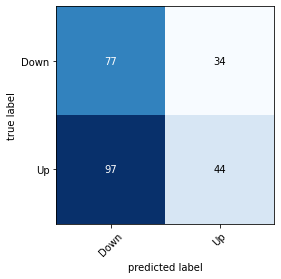

In [18]:
class_labels = ["Down", "Up"] # took the Up dummy column as my independent variable, so 1 = Up
predict_class = pd.Series(data=0, index=predict_prob.index)
predict_class.loc[predict_prob > 0.5] = 1
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

In [19]:
(predict_class != y_test).mean()

0.5198412698412699

## LDA
Have to switch over to sklearn for this

In [20]:
y_train = pd.get_dummies(train_df["Direction"])["Up"]
X_train = train_df[["Lag1", "Lag2"]]
y_test = pd.get_dummies(test_df["Direction"])["Up"]
X_test = test_df[["Lag1", "Lag2"]]

In [21]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [22]:
printm("Prior probabilities of the groups: ")
lda.priors_

Prior probabilities of the groups: 

array([0.49198397, 0.50801603])

In [23]:
lda.coef_

array([[-0.05544078, -0.0443452 ]])

The coefficients aren't the same as in R. Will have to figure out why that might be

[R lda docs](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/lda.html)

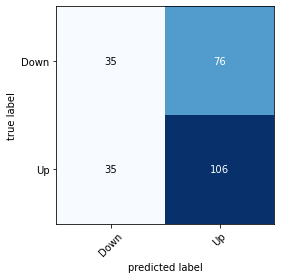

In [24]:
class_labels = ["Down", "Up"] # took the Up dummy column as my independent variable, so 1 = Up
predict_class = lda.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
ax.set_ylim(len(confusion_mat)-0.5, -0.5) # have to keep this in until matplotlib 3.1.2 comes out
#https://github.com/matplotlib/matplotlib/issues/14751
plt.show()

It has the exact same confusion matrix though, not going to worry about the different coefficients much in that case.

## QDA

In [25]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

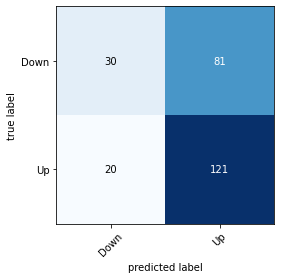

In [26]:
class_labels = ["Down", "Up"] # took the Up dummy column as my independent variable, so 1 = Up
predict_class = qda.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

## KNN

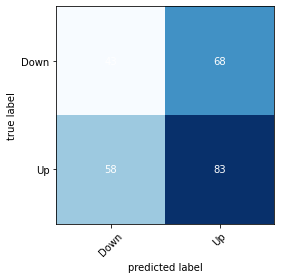

In [27]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
predict_class = knn.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

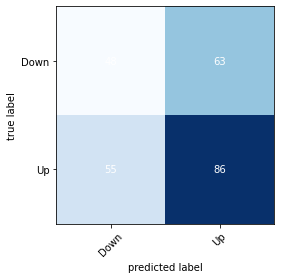

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predict_class = knn.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

### KNN on Caravan Insurance

In [29]:
df = sm.datasets.get_rdataset("Caravan", "ISLR", cache=True).data

In [30]:
df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


In [31]:
df["Purchase"].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [32]:
share = df["Purchase"].value_counts().loc["Yes"] / len(df)
printm(f"Purchase share: {share:.2%}")

Purchase share: 5.98%

Want to use a standard scaler on all predictors so that they have a mean of 0 and a standard deviation of one

In [33]:
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=1)
pipe = make_pipeline(scaler, knn)
y = pd.get_dummies(df["Purchase"])["Yes"]
X = df.drop(columns=["Purchase"])
mask = df["Purchase"] == "Yes"
df["Purchase"] = 0
df.loc[mask, "Purchase"] = 1
y_train = y.iloc[1000:]
X_train = X.iloc[1000:]
y_test = y.iloc[:1000]
X_test = X.iloc[:1000]
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [34]:
y_pred = pipe.predict(X_test)

In [35]:
(y_pred != y_test).mean()

0.117

In [36]:
(y_test == 1).mean()

0.059

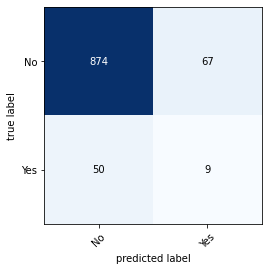

In [37]:
class_labels = ["No", "Yes"]
confusion_mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

The model does the same thing for n_neighbors = 3 and 5

In [38]:
param_grid = {'kneighborsclassifier__n_neighbors': [1, 3, 5]}
search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.936):
{'kneighborsclassifier__n_neighbors': 5}


In [39]:
y_pred = search.predict(X_test)

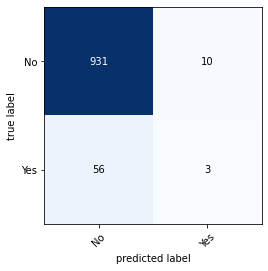

In [40]:
confusion_mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
ax.set_ylim(len(confusion_mat)-0.5, -0.5) # have to keep this in until matplotlib 3.1.2 comes out
#https://github.com/matplotlib/matplotlib/issues/14751
plt.show()

### Logit on Caravan

In [41]:
skl_logit = LogisticRegression(penalty="none", solver="newton-cg", fit_intercept=True)
pipe = make_pipeline(scaler, skl_logit)
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(penalty='none', solver='newton-cg'))])

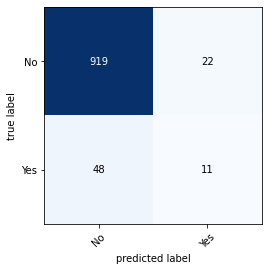

In [42]:
y_pred_prob = pipe.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': y_pred_prob[:,1] > .25})
confusion_mat = confusion_matrix(cm_df["True"], cm_df["Pred"])
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

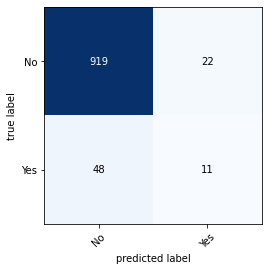

In [43]:
glm_model = LogisticRegression(solver="newton-cg", fit_intercept=True, C=1e9, max_iter=1_000).fit(X_train, y_train) # Large C for no regularization
y_pred_prob = glm_model.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': y_pred_prob[:,1] > .25})
confusion_mat = confusion_matrix(cm_df["True"], cm_df["Pred"])
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

Ok, same general result in SKL whether I scale or not (that's good), let's try with statsmodels

In [44]:
df_train = df.loc[1000:]

In [45]:
logit = sm.Logit(df_train["Purchase"], df_train.drop(columns="Purchase")).fit(method="ncg", maxiter=1_000)

Optimization terminated successfully.
         Current function value: 0.192489
         Iterations: 44
         Function evaluations: 57
         Gradient evaluations: 57
         Hessian evaluations: 44


In [46]:
regressors = " + ".join(col for col in df_train.drop(columns="Purchase").columns)
regressors
formula = "Purchase ~ " + regressors
mod = smf.logit(formula=formula, data=df_train)
res = mod.fit(method="ncg", maxiter=1_000)

Optimization terminated successfully.
         Current function value: 0.192013
         Iterations: 45
         Function evaluations: 64
         Gradient evaluations: 64
         Hessian evaluations: 45


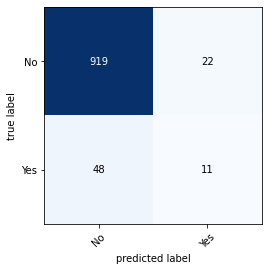

In [47]:
y_pred_prob = res.predict(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': y_pred_prob > .25})
confusion_mat = confusion_matrix(cm_df["True"], cm_df["Pred"])
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()